In [3]:
from pdb import set_trace
from typing import (
    List,
    Dict
)
from functools import partial

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_kernels

import gc4eptn
from gc4eptn import dataloaders
from gc4eptn.utils import norms
from gc4eptn.pngs import (
    run_ggm_pngs_exp, 
    run_pngs, 
)
from gc4eptn.utils.utils import (
    get_dataloader,
    to_adjacency,
    build_experiment_path,
    filter_function_kwargs,
    lambda_grid_R_max_min,
    lambda_grid_R_max_square,
    exp_log_grid,
)
from gc4eptn.utils.plotting import (
    plot_eptn_ground_truths,
    R_mag_ang_plots,
)
from gc4eptn.utils.kernels import (
    weighted_kernel,
    corr,
    cov,
    gram,
    rational_quadratic,
)
from gc4eptn.utils.metrics import (
    graph_fscore,
    graph_fbscore,
    graph_precision,
    graph_recall,
    hamming_distance,
    ebic,
)

np.set_printoptions(suppress=True)
%load_ext autoreload
%autoreload 2

### Utils

In [4]:
rqk = partial(rational_quadratic, length_scale=50, alpha=1.0)
rbf = partial(pairwise_kernels, metric='rbf')

wcorr = partial(weighted_kernel, kernel=corr)
wcov = partial(weighted_kernel, kernel=cov)
wgram = partial(weighted_kernel, kernel=partial(gram, transpose=True))
wrq = partial(weighted_kernel, kernel=rqk)
wrbf = partial(weighted_kernel, kernel=rbf)

In [5]:
fstandardize = partial(
    norms.feature_norm,
    norm_fn=norms.standardize,
    features=['V_mag', 'V_ang', 'I_ang', 'I_mag']
)

### Data Parameters

**WARNING: PNGR only works for datasets with current features! MATPOWER datasets do not work!**

In [6]:
### Dataset Params ###
dataset_type = 'rtds'
dataset_version = 'v5'
difficulty = 'novice'
topology = 'complete'

### Load and Number of Sample Params ###
random = True # If n_samples < total samples then randomly select subset

# All loads
# load = ['low', 'medium', 'high']
# n_samples = 5400

# High load
load = 'high'
n_samples = 1800 

# Medium load
# load = 'medium'
# n_samples = 1800 

# Low load
# load = 'low'
# n_samples = 1800

### RNG Seed ###
rng = np.random.default_rng(seed=0)

### Norm Type ###
norm_type = 'fstandardize'

### Kernel Type ###
R_func_name = 'rqk'
assert R_func_name in globals()

### Use parallel wdges for flow PMU data (simple or multi-graph) ###
drop_parallel_currents = False # Enable multi-graph for original EPTN if False

In [7]:
pmu_class = get_dataloader(dataset_type, dataset_version, difficulty)

data_type_path = build_experiment_path(
    subdirs=[
        dataset_type,
        dataset_version,
        'pngs',
        'single-exp',
        difficulty,
        topology,
        'simple' if drop_parallel_currents else 'multi-edge'
    ]
) 
print(f"data type path: {data_type_path}")
save_dir_path = build_experiment_path(
    subdirs=[
        '-'.join(load) if isinstance(load, list) else load,
        norm_type,
        n_samples,
        R_func_name,
    ],
    path=data_type_path
)
print(f"Save dir path: {save_dir_path}")

data type path: /home/ben/space/modl/gc4eptn/exps/rtds/v5/pngs/single-exp/novice/complete/multi-edge
Save dir path: /home/ben/space/modl/gc4eptn/exps/rtds/v5/pngs/single-exp/novice/complete/multi-edge/high/fstandardize/1800/rqk


# Data Loading

## Load Data for PNGR (Flow Graph Data)

In [8]:
flow_pmuds = pmu_class(
    load=load,
    topology=topology,
    drop_current=False,
    drop_parallel_currents=drop_parallel_currents,
)
flow_pmuds.file_name = 'Data_pu_Complete.csv'
flow_pmuds.load_data()
flow_pmuds.df

,Time,BUS5_01_V_ang,BUS5_01_V_mag,BUS5_03_I_ang,BUS5_03_I_mag,BUS6_01_V_ang,BUS6_01_V_mag,BUS6_03_I_ang,BUS6_03_I_mag,BUS6_04_I_ang,...,BUS10_01_V_ang,BUS10_01_V_mag,BUS10_02_I_ang,BUS10_02_I_mag,BUS10_04_I_ang,BUS10_04_I_mag,BUS11_01_V_ang,BUS11_01_V_mag,BUS11_02_I_ang,BUS11_02_I_mag
0,0.0000,0.881667,1.006510,0.736893,2.343051,0.705696,0.978039,3.872345,2.343907,0.613379,...,0.228098,0.983388,0.171335,4.773429,3.420001,2.395714,0.407964,1.008326,0.284443,2.395193
1,0.0333,0.881667,1.006508,0.736893,2.343048,0.705695,0.978038,3.872345,2.343904,0.613379,...,0.228097,0.983386,0.171335,4.773424,3.420001,2.395711,0.407964,1.008325,0.284443,2.395190
2,0.0666,0.881667,1.006509,0.736893,2.343051,0.705696,0.978038,3.872345,2.343906,0.613379,...,0.228098,0.983387,0.171335,4.773428,3.420001,2.395713,0.407964,1.008325,0.284443,2.395192
3,0.0999,0.881667,1.006509,0.736893,2.343049,0.705695,0.978038,3.872345,2.343905,0.613379,...,0.228097,0.983387,0.171335,4.773425,3.420001,2.395711,0.407964,1.008325,0.284443,2.395190
4,0.1332,0.881667,1.006509,0.736893,2.343050,0.705696,0.978038,3.872345,2.343905,0.613379,...,0.228098,0.983387,0.171335,4.773426,3.420001,2.395712,0.407964,1.008325,0.284443,2.395191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1797,59.8401,0.881667,1.006509,0.736893,2.343050,0.705695,0.978038,3.872345,2.343905,0.613379,...,0.228098,0.983387,0.171335,4.773426,3.420001,2.395712,0.407964,1.008325,0.284443,2.395191
1798,59.8734,0.881667,1.006509,0.736893,2.343050,0.705696,0.978038,3.872345,2.343905,0.613379,...,0.228098,0.983387,0.171335,4.773426,3.420001,2.395712,0.407964,1.008325,0.284443,2.395191
1799,59.9067,0.881667,1.006509,0.736893,2.343049,0.705695,0.978038,3.872345,2.343905,0.613379,...,0.228098,0.983387,0.171335,4.773425,3.420001,2.395711,0.407964,1.008325,0.284443,2.395190
1800,59.9400,0.881667,1.006509,0.736893,2.343051,0.705696,0.978038,3.872345,2.343906,0.613379,...,0.228098,0.983387,0.171335,4.773428,3.420001,2.395713,0.407964,1.008325,0.284443,2.395192


# Load Data for GGM (Network Graph Data)

In [9]:
norm_fn = globals()[norm_type]
R_func = globals()[R_func_name]

# Always drop multi-edges when working with GGM
net_pmuds = pmu_class(
    load=load,
    topology=topology, 
    drop_current=True,
    drop_parallel_currents=True, # GGMs do not support parallel currents
)
net_pmuds.load_data()
# net_pmuds.labels = {n:i for n, i in enumerate(np.arange(1,len(net_pmuds.nodes)+1))}
net_pmuds.build_graph_data(
    n=n_samples, 
    random=random, 
    norm_fn=norm_fn,
    rng=rng,
)
R = R_func(net_pmuds.graph_df)

display(net_pmuds.df)
display(net_pmuds.graph_df)

,Time,BUS5_01_V_ang,BUS5_01_V_mag,BUS6_01_V_ang,BUS6_01_V_mag,BUS7_01_V_ang,BUS7_01_V_mag,BUS8_01_V_ang,BUS8_01_V_mag,BUS9_01_V_ang,BUS9_01_V_mag,BUS10_01_V_ang,BUS10_01_V_mag,BUS11_01_V_ang,BUS11_01_V_mag
0,0.0000,0.881667,133655.0000,0.705696,129874.3125,0.5589,127607.1406,0.317674,125985.3359,0.081219,128984.5703,0.228098,130584.5859,0.407964,133896.1563
1,0.0333,0.881667,133654.8281,0.705695,129874.1641,0.5589,127606.9922,0.317674,125985.1797,0.081219,128984.4219,0.228097,130584.4297,0.407964,133895.9844
2,0.0666,0.881667,133654.9531,0.705696,129874.2734,0.5589,127607.1094,0.317674,125985.2969,0.081219,128984.5391,0.228098,130584.5547,0.407964,133896.1094
3,0.0999,0.881667,133654.8594,0.705695,129874.1719,0.5589,127607.0078,0.317674,125985.1953,0.081219,128984.4375,0.228097,130584.4531,0.407964,133896.0156
4,0.1332,0.881667,133654.8906,0.705696,129874.2188,0.5589,127607.0469,0.317674,125985.2344,0.081219,128984.4766,0.228098,130584.4922,0.407964,133896.0469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1797,59.8401,0.881667,133654.8906,0.705695,129874.2188,0.5589,127607.0469,0.317674,125985.2344,0.081219,128984.4766,0.228098,130584.4922,0.407964,133896.0469
1798,59.8734,0.881667,133654.8906,0.705696,129874.2188,0.5589,127607.0469,0.317674,125985.2344,0.081219,128984.4766,0.228098,130584.4922,0.407964,133896.0469
1799,59.9067,0.881667,133654.8594,0.705695,129874.1797,0.5589,127607.0078,0.317674,125985.1953,0.081219,128984.4375,0.228098,130584.4531,0.407964,133896.0000
1800,59.9400,0.881667,133654.9531,0.705696,129874.2734,0.5589,127607.1094,0.317674,125985.2969,0.081219,128984.5391,0.228098,130584.5547,0.407964,133896.1094


,01_V_ang_52.6806,01_V_mag_52.6806,01_V_ang_33.633,01_V_mag_33.633,01_V_ang_10.3563,01_V_mag_10.3563,01_V_ang_28.5048,01_V_mag_28.5048,01_V_ang_32.3343,01_V_mag_32.3343,...,01_V_ang_25.0749,01_V_mag_25.0749,01_V_ang_33.0003,01_V_mag_33.0003,01_V_ang_49.4172,01_V_mag_49.4172,01_V_ang_56.4102,01_V_mag_56.4102,01_V_ang_14.0193,01_V_mag_14.0193
BUS5,1.652290,1.313762,1.652290,1.313739,1.652290,1.313768,1.652290,1.313802,1.652290,1.313785,...,1.652290,1.313768,1.652290,1.313802,1.652290,1.313751,1.652290,1.313802,1.652290,1.313751
BUS6,0.971694,-0.077096,0.971694,-0.077116,0.971694,-0.077093,0.971694,-0.077058,0.971693,-0.077073,...,0.971694,-0.077093,0.971694,-0.077058,0.971693,-0.077107,0.971693,-0.077058,0.971693,-0.077107
BUS7,0.403939,-0.911153,0.403939,-0.911173,0.403939,-0.911153,0.403939,-0.911119,0.403939,-0.911130,...,0.403939,-0.911153,0.403939,-0.911119,0.403939,-0.911168,0.403939,-0.911119,0.403939,-0.911168
BUS8,-0.529038,-1.507795,-0.529039,-1.507815,-0.529038,-1.507795,-0.529038,-1.507760,-0.529039,-1.507772,...,-0.529039,-1.507792,-0.529039,-1.507760,-0.529039,-1.507809,-0.529039,-1.507760,-0.529038,-1.507809
BUS9,-1.443566,-0.404416,-1.443566,-0.404437,-1.443566,-0.404416,-1.443566,-0.404382,-1.443566,-0.404393,...,-1.443566,-0.404416,-1.443566,-0.404382,-1.443566,-0.404431,-1.443566,-0.404382,-1.443566,-0.404431
BUS10,-0.875490,0.184207,-0.875490,0.184184,-0.875490,0.184207,-0.875490,0.184241,-0.875490,0.184230,...,-0.875490,0.184207,-0.875490,0.184241,-0.875490,0.184192,-0.875490,0.184241,-0.875490,0.184192
BUS11,-0.179827,1.402480,-0.179827,1.402457,-0.179827,1.402480,-0.179827,1.402520,-0.179827,1.402503,...,-0.179827,1.402480,-0.179827,1.402520,-0.179828,1.402463,-0.179827,1.402515,-0.179827,1.402463


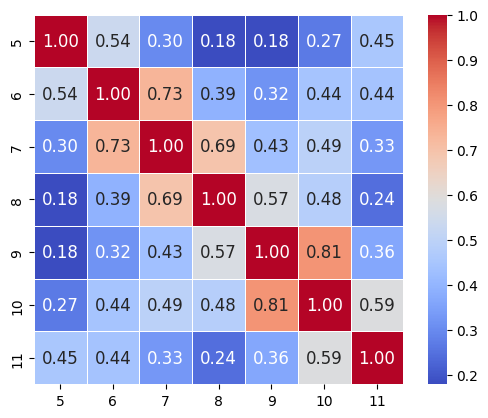

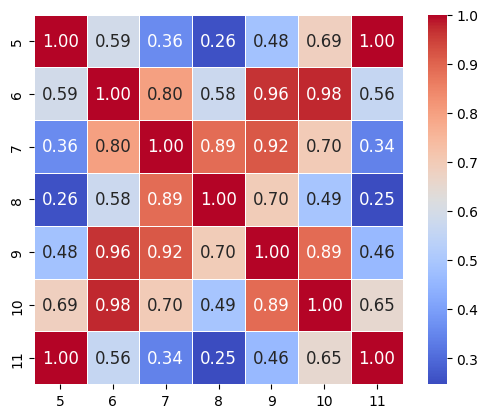

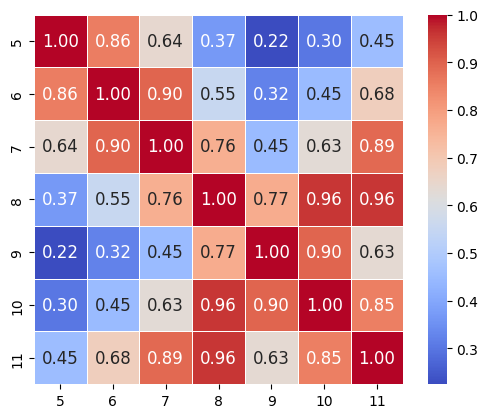

In [10]:
R_mag_ang_plots(
    R_func=R_func,
    pmu_class=pmu_class,
    load_kwargs=dict(
        load=load,
        topology=topology, 
    ),
    build_kwargs=dict(
        n=n_samples,
        random=False,
        norm_fn=norm_fn,
        rng=rng,
    ),
    filename=R_func_name,
    save_path=save_dir_path,
    annot_kws=dict(fontsize=12),
    verbose=True
)

# Ground Truth

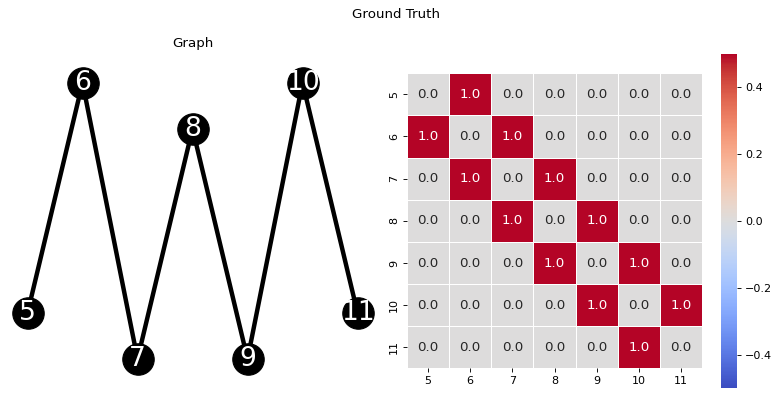

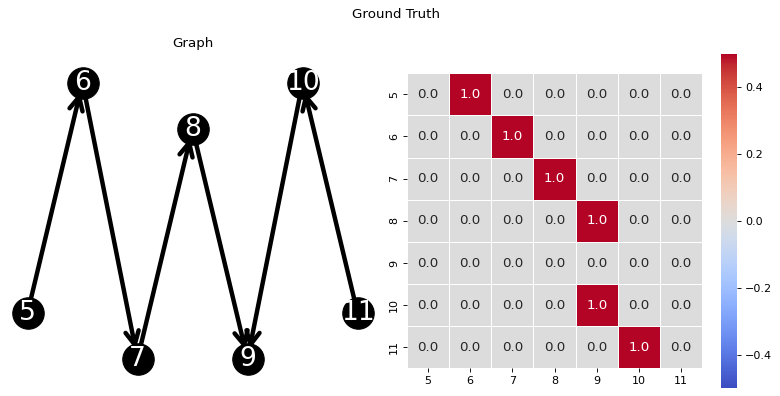

In [11]:
plot_eptn_ground_truths(
    data_type_path, 
    net_pmuds=net_pmuds, 
    flow_pmuds=net_pmuds, 
    annot_kws=dict(fontsize=12), 
    verbose=True
)

# Experiments

In [12]:
metrics = {
    'hd': dict(
        fn=hamming_distance,
        type='lowest'
    ),
    'ebic': dict(
        fn=partial(ebic, gamma=0.5), 
        type='lowest'
    ),
    'f-score': dict(
        fn=graph_fscore,
        type='highest'
    ),
    'fb-score': dict(
        fn=partial(graph_fbscore, beta=2),
        type='highest'
    ),
    'precision': dict(
        fn=graph_precision,
        type='highest'
    ),
    'recall': dict(
        fn=graph_recall,
        type='highest'
    ),
}

def compute_metrics(A, A_hat, directed=False):
    results = {}
    results['f-score'] = metrics['f-score']['fn'](A, A_hat)
    results['fb-score'] = metrics['fb-score']['fn'](A, A_hat)
    results['precision'] = metrics['precision']['fn'](A, A_hat)
    results['recall'] = metrics['recall']['fn'](A, A_hat)
    results['hd'] = metrics['hd']['fn'](A, A_hat, directed)
    return results

In [13]:
select_best_metric_name = 'fb-score'
select_best_metric = metrics[select_best_metric_name]
pngs_min_threshold = 0.2

algo_metrics_s1 = {}
algo_metrics_s2 = {}
ggm_params = {}

lambda_grid=exp_log_grid(start=0.001, end=200, n=100, round_dec=4)
ggmncv_kwargs = {
    'penalize_diagonal': False,
    'LLA': False,
    'select': 'lambda',
    'lambda': lambda_grid, 
    'ic': 'ebic'
}

save_path_score = save_dir_path/select_best_metric_name
save_path_score

PosixPath('/home/ben/space/modl/gc4eptn/exps/rtds/v5/pngs/single-exp/novice/complete/multi-edge/high/fstandardize/1800/rqk/fb-score')

## GLasso

R[write to console]: selecting lambda



  |======================================================================| 100%

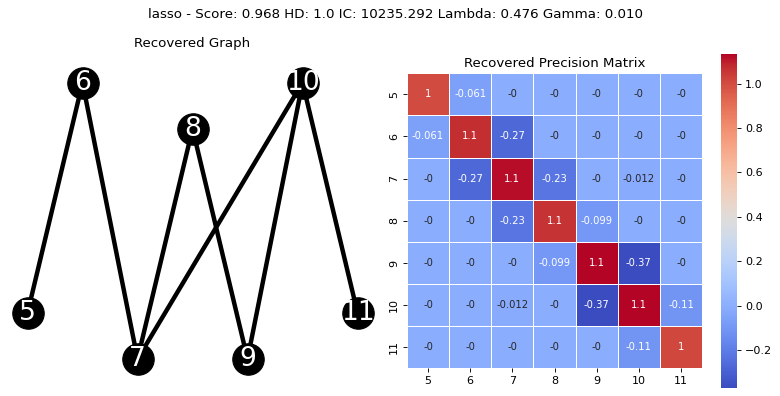

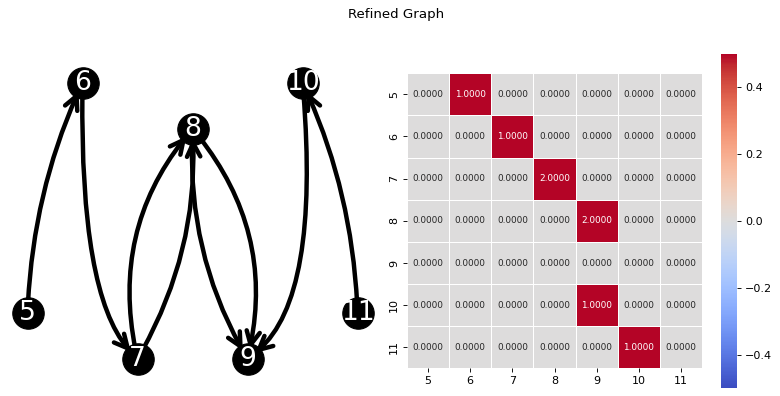

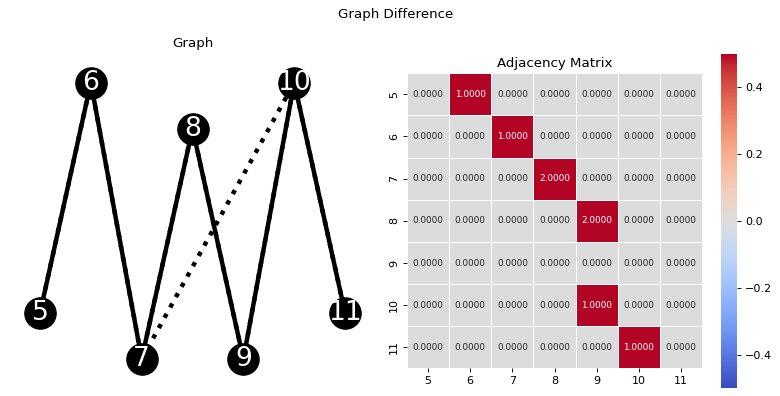

In [14]:
s1_metrics, s2_metrics, params,pngs = run_ggm_pngs_exp(
    net_pmuds=net_pmuds,
    flow_pmuds=flow_pmuds,
    R=R,
    penalty='lasso',
    n_samples=n_samples,
    pngs_score_type='sum',
    pngs_min_threshold=pngs_min_threshold,
    select_best_metric_fn=select_best_metric['fn'],
    select_best_metric_type=select_best_metric['type'],
    ggm_metrics_fn=compute_metrics,
    refined_metrics_fn=partial(compute_metrics, directed=True),
    ggmncv_kwargs=ggmncv_kwargs,
    save_path=save_path_score,
    include_ggm_result_metrics=['ic'],
)
algo_metrics_s1['GLasso'] = s1_metrics
algo_metrics_s2['GLasso'] = s2_metrics
ggm_params['Glasso'] = params

## SCAD

R[write to console]: selecting lambda



  |======================================================================| 100%

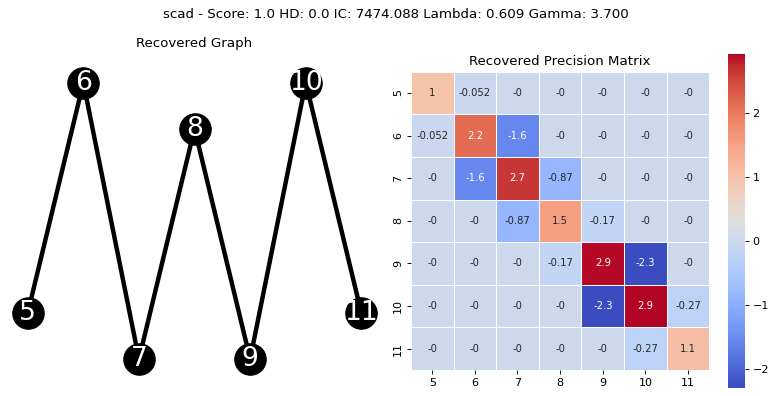

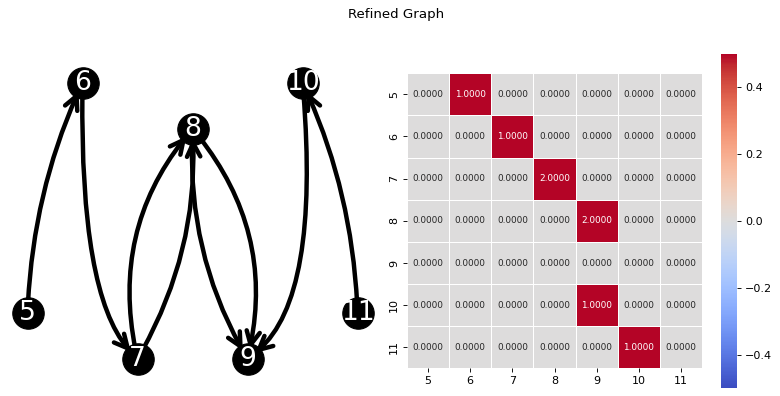

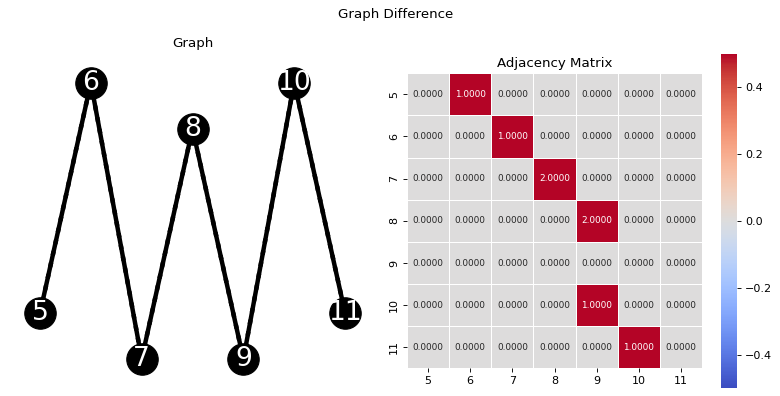

In [15]:
s1_metrics, s2_metrics, params,pngs = run_ggm_pngs_exp(
    net_pmuds=net_pmuds,
    flow_pmuds=flow_pmuds,
    R=R,
    penalty='scad',
    n_samples=n_samples,
    pngs_score_type='sum',
    pngs_min_threshold=pngs_min_threshold,
    select_best_metric_fn=select_best_metric['fn'],
    select_best_metric_type=select_best_metric['type'],
    ggm_metrics_fn=compute_metrics,
    refined_metrics_fn=partial(compute_metrics, directed=True),
    ggmncv_kwargs=ggmncv_kwargs,
    save_path=save_path_score,
    include_ggm_result_metrics=['ic', 'score'],
)
algo_metrics_s1['SCAD'] = s1_metrics
algo_metrics_s2['SCAD'] = s2_metrics
ggm_params['SCAD'] = params

## MCP

R[write to console]: selecting lambda



  |======================================================================| 100%

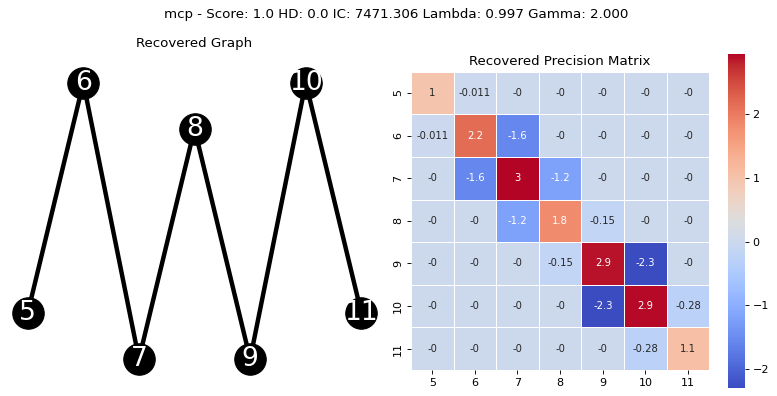

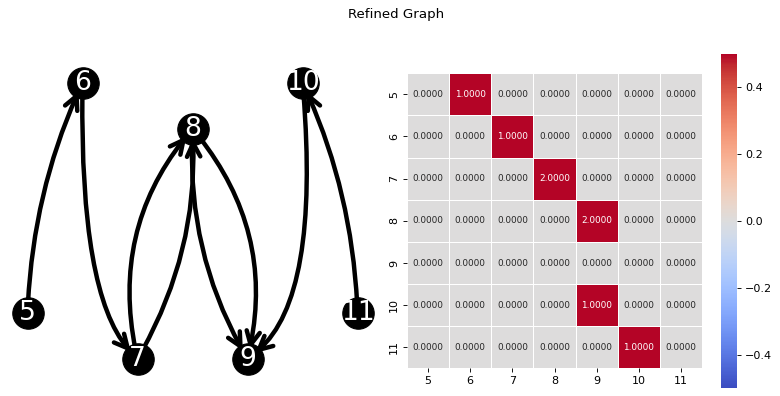

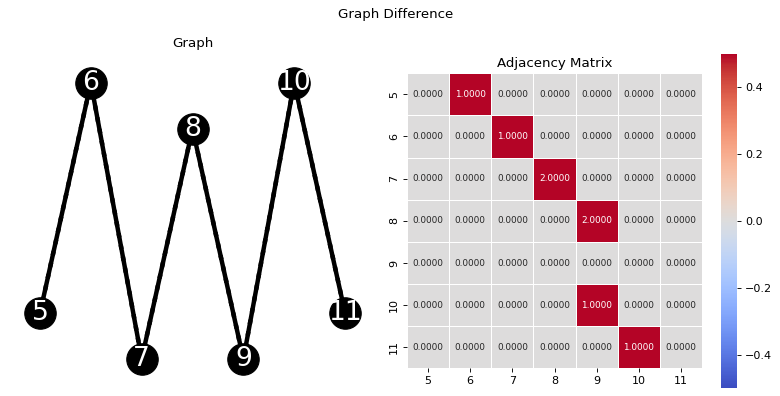

In [16]:
s1_metrics, s2_metrics, params,pngs = run_ggm_pngs_exp(
    net_pmuds=net_pmuds,
    flow_pmuds=flow_pmuds,
    R=R,
    penalty='mcp',
    n_samples=n_samples,
    pngs_score_type='sum',
    pngs_min_threshold=pngs_min_threshold,
    select_best_metric_fn=select_best_metric['fn'],
    select_best_metric_type=select_best_metric['type'],
    ggm_metrics_fn=compute_metrics,
    refined_metrics_fn=partial(compute_metrics, directed=True),
    ggmncv_kwargs=ggmncv_kwargs,
    save_path=save_path_score,
    include_ggm_result_metrics=['ic', 'score'],
)
algo_metrics_s1['MCP'] = s1_metrics
algo_metrics_s2['MCP'] = s2_metrics
ggm_params['MCP'] = params

## ATAN

R[write to console]: selecting lambda



  |======================================================================| 100%

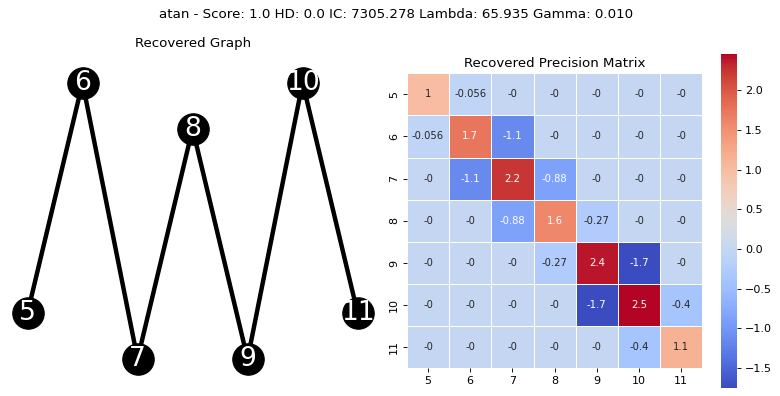

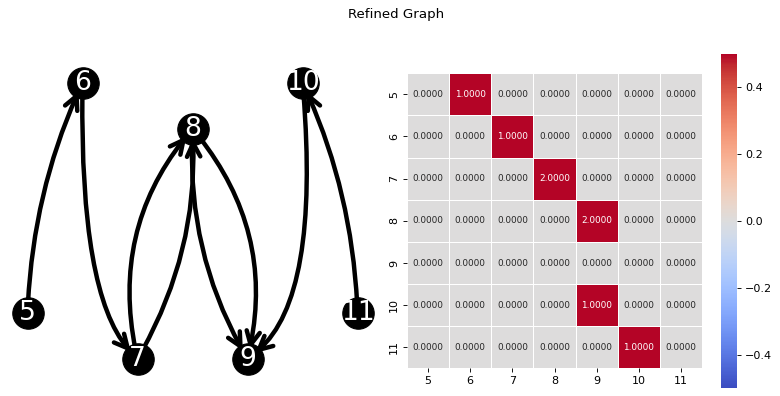

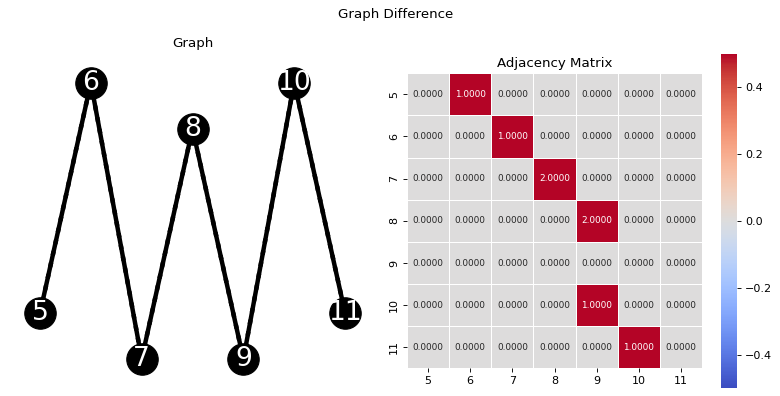

In [17]:
s1_metrics, s2_metrics, params,pngs = run_ggm_pngs_exp(
    net_pmuds=net_pmuds,
    flow_pmuds=flow_pmuds,
    R=R,
    penalty='atan',
    n_samples=n_samples,
    pngs_score_type='sum',
    pngs_min_threshold=pngs_min_threshold,
    select_best_metric_fn=select_best_metric['fn'],
    select_best_metric_type=select_best_metric['type'],
    ggm_metrics_fn=compute_metrics,
    refined_metrics_fn=partial(compute_metrics, directed=True),
    ggmncv_kwargs=ggmncv_kwargs,
    save_path=save_path_score,
    include_ggm_result_metrics=['ic', 'score'],
)
algo_metrics_s1['ATAN'] = s1_metrics
algo_metrics_s2['ATAN'] = s2_metrics
ggm_params['ATAN'] = params

## SELO

R[write to console]: selecting lambda



  |======================================================================| 100%

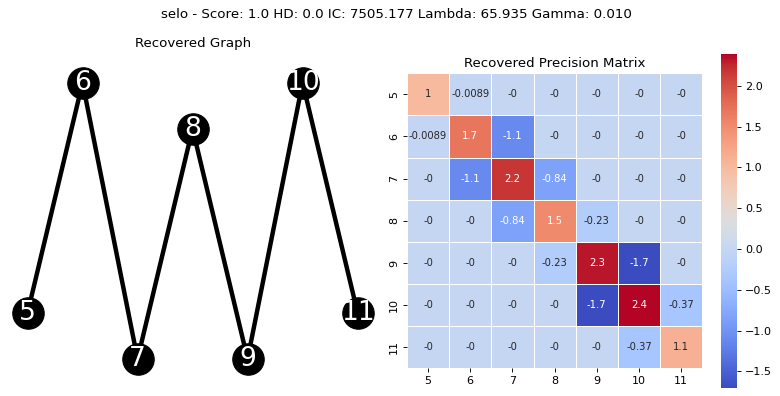

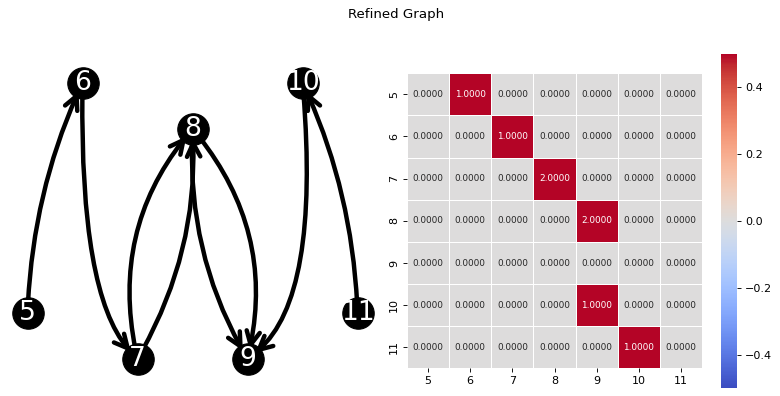

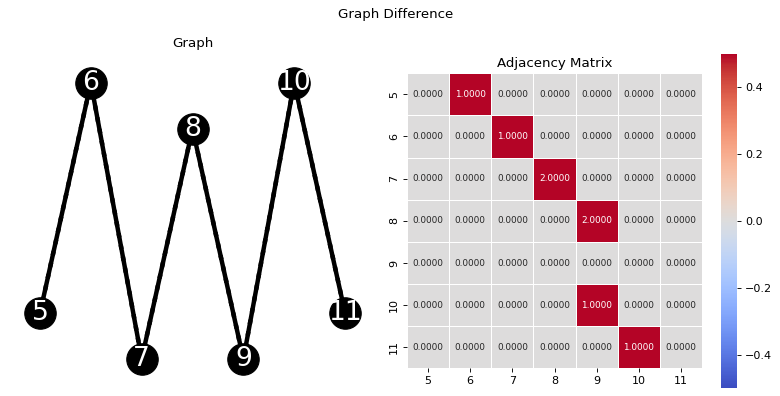

In [18]:
s1_metrics, s2_metrics, params,pngs = run_ggm_pngs_exp(
    net_pmuds=net_pmuds,
    flow_pmuds=flow_pmuds,
    R=R,
    penalty='selo',
    n_samples=n_samples,
    pngs_score_type='sum',
    pngs_min_threshold=pngs_min_threshold,
    select_best_metric_fn=select_best_metric['fn'],
    select_best_metric_type=select_best_metric['type'],
    ggm_metrics_fn=compute_metrics,
    refined_metrics_fn=partial(compute_metrics, directed=True),
    ggmncv_kwargs=ggmncv_kwargs,
    save_path=save_path_score,
    include_ggm_result_metrics=['ic', 'score'],
)
algo_metrics_s1['SELO'] = s1_metrics
algo_metrics_s2['SELO'] = s2_metrics
ggm_params['SELO'] = params

## EXP

In [19]:
# Set to True to include EXP
# Usually does not have great results
if False:
    s1_metrics, s2_metrics, params,pngs = run_ggm_pngs_exp(
        net_pmuds=net_pmuds,
        flow_pmuds=flow_pmuds,
        R=R,
        penalty='exp',
        n_samples=n_samples,
        pngs_score_type='sum',
        pngs_min_threshold=pngs_min_threshold,
        select_best_metric_fn=select_best_metric['fn'],
        select_best_metric_type=select_best_metric['type'],
        ggm_metrics_fn=compute_metrics,
        refined_metrics_fn=partial(compute_metrics, directed=True),
        ggmncv_kwargs=ggmncv_kwargs,
        save_path=save_path_score,
        include_ggm_result_metrics=['ic', 'score'],
    )
    algo_metrics_s1['EXP'] = s1_metrics
    algo_metrics_s2['EXP'] = s2_metrics
    ggm_params['EXP'] = params

## Summary

### Stage 1: Network Graph Estimation Metrics

In [20]:
summary = pd.DataFrame.from_dict(algo_metrics_s1, orient='index')
summary.rename(columns=dict(score=select_best_metric_name), inplace=True)
summary.index = summary.index.str.upper()
summary.to_csv(save_path_score/'stage-1-metrics.csv')
with open(save_path_score/'stage-1-metrics.tex', 'w') as tf:
     tf.write(summary.to_latex(float_format="%.2f", longtable=False))
display(summary)

,f-score,fb-score,precision,recall,hd,ic,fb-score
GLASSO,0.923077,0.967742,0.857143,1.0,1.0,10235.291515,NaN
SCAD,1.000000,1.000000,1.000000,1.0,0.0,7474.087826,1.0
MCP,1.000000,1.000000,1.000000,1.0,0.0,7471.306250,1.0
ATAN,1.000000,1.000000,1.000000,1.0,0.0,7305.277744,1.0
SELO,1.000000,1.000000,1.000000,1.0,0.0,7505.177195,1.0


### Stage 2: Refinement and Flow Graph Estimation Metrics

In [21]:
summary = pd.DataFrame.from_dict(algo_metrics_s2, orient='index')
summary.index = summary.index.str.upper()
summary.to_csv(save_path_score/'stage-2-metrics.csv')
with open(save_path_score/'stage-2-metrics.tex', 'w') as tf:
     tf.write(summary.to_latex(float_format="%.2f", longtable=False))
display(summary)

,f-score,fb-score,precision,recall,hd
GLASSO,1.0,1.0,1.0,1.0,0
SCAD,1.0,1.0,1.0,1.0,0
MCP,1.0,1.0,1.0,1.0,0
ATAN,1.0,1.0,1.0,1.0,0
SELO,1.0,1.0,1.0,1.0,0


### GGM Params

In [22]:
summary = pd.DataFrame.from_dict(ggm_params, orient='index')
summary.index = summary.index.str.upper()
summary.to_csv(save_path_score/'ggm-params.csv')
with open(save_path_score/'ggm-params.tex', 'w') as tf:
     tf.write(summary.to_latex(float_format="%.2f", longtable=False))
display(summary)

,lambda,gamma
GLASSO,0.4757,0.01
SCAD,0.6087,3.70
MCP,0.9967,2.00
ATAN,65.9353,0.01
SELO,65.9353,0.01
